Data Loaded Successfully
Shape: (6255, 18)
   Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-03-05      0.914805             0    -0.767955   -1.598328   
1      1 2010-03-12      0.707959             0    -0.155815   -1.506821   
2      1 2010-03-19      0.767132             0    -0.329861   -1.391349   
3      1 2010-03-26      0.644951             0    -0.499568   -1.365204   
4      1 2010-04-02      0.986875             0     0.087089   -1.393527   

        CPI  Unemployment  year  month  week  day_of_week  is_weekend  \
0  1.010624      0.056964  2010      3     9            4           0   
1  1.011399      0.056964  2010      3    10            4           0   
2  1.007206      0.056964  2010      3    11            4           0   
3  1.002185      0.056964  2010      3    12            4           0   
4  0.997164     -0.101907  2010      4    13            4           0   

   sales_lag_1  sales_lag_2  sales_lag_4  rolling_mean_4w  ro

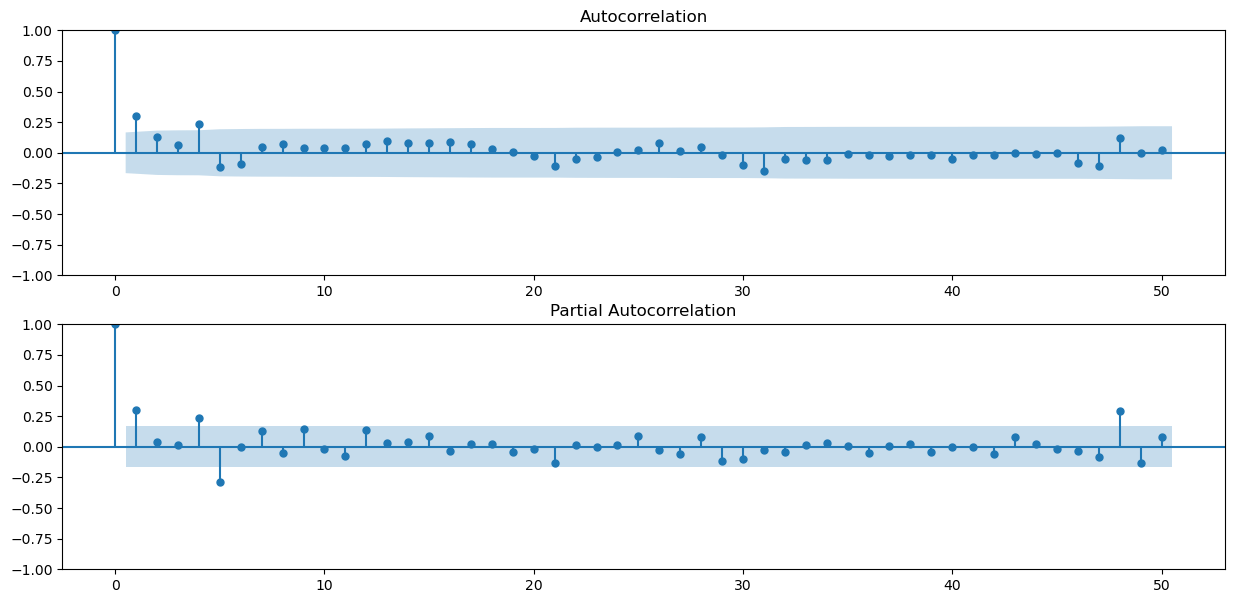

Interpreting the plots:
1. Look for a pattern in the ACF plot to identify the seasonal component (S and Q). A spike every 52 weeks would indicate a seasonal period of 52.
2. Look at the last significant lag in the ACF plot to determine the moving average parameter (q).
3. Look at the last significant lag in the PACF plot to determine the autoregressive parameter (p).


c:\Users\FR4001TU\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\FR4001TU\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\FR4001TU\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



SARIMA Model Training Complete.
                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  139
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                  22.178
Date:                            Fri, 29 Aug 2025   AIC                            -34.355
Time:                                    00:34:30   BIC                            -27.026
Sample:                                03-05-2010   HQIC                           -31.926
                                     - 10-26-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0592      0.263     -0.225      0.822      -0.575       0.456
ma

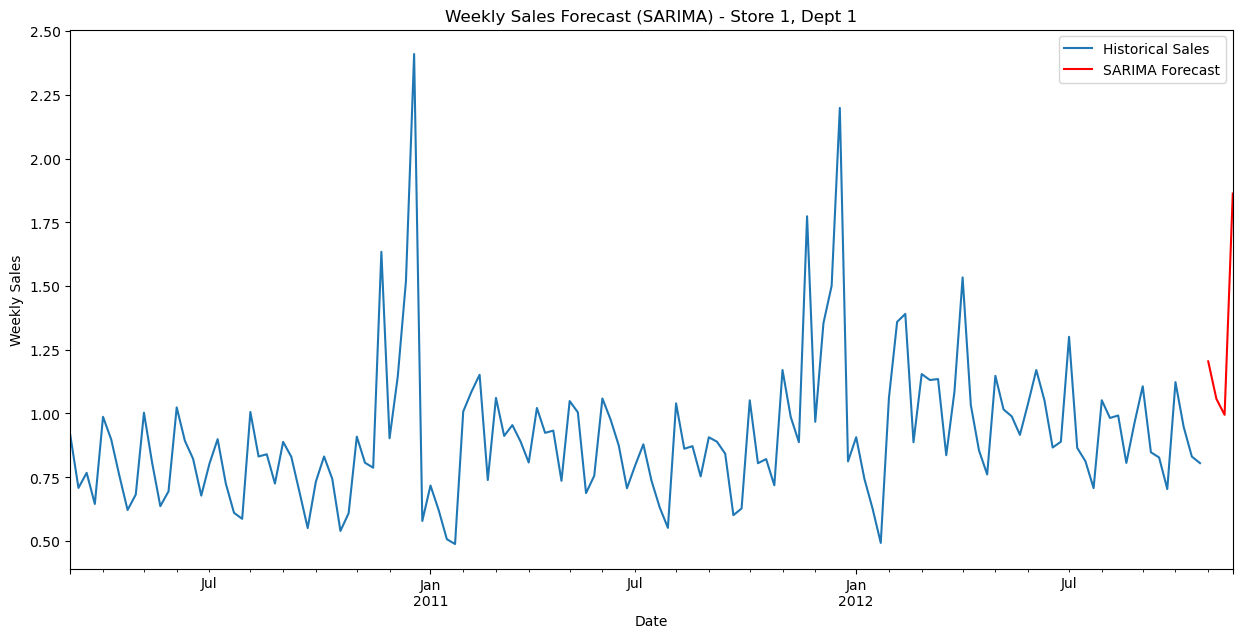


SARIMA Forecasts Saved to: ../data/processed/sarima_forecasts.csv
        Date  SARIMA_Forecasted_Sales
0 2012-11-02                 1.204338
1 2012-11-09                 1.057075
2 2012-11-16                 0.994635
3 2012-11-23                 1.862639


In [36]:
# ==========================
# Sales Forecasting Project - Advanced Time Series Forecasting (SARIMA)
# ==========================

## 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os

## 2. Load Processed Data
data_path = "../data/processed/walmart_with_features.csv"
try:
    df = pd.read_csv(data_path, parse_dates=["Date"])
    print("Data Loaded Successfully")
    print("Shape:", df.shape)
    print(df.head())
except FileNotFoundError:
    print(f"Error: Data file not found at {data_path}. Please run the 01_data_preprocessing notebook first.")
    exit()

if 'Dept' not in df.columns:
    df['Dept'] = 1
    print("\nWarning: 'Dept' column not found in data. A dummy column has been created.")

# Set the 'Date' column as the index for time series analysis
df.set_index("Date", inplace=True)

## 3. Select a Specific Store & Department
STORE_ID = 1
DEPT_ID = 1

df_filtered = df[(df["Store"] == STORE_ID) & (df["Dept"] == DEPT_ID)]

if df_filtered.empty:
    print(f"Warning: No data found for Store {STORE_ID} and Dept {DEPT_ID}. Please check your raw data.")
else:
    print(f"Filtered data for Store {STORE_ID} and Dept {DEPT_ID}")
    print("Shape:", df_filtered.shape)

sales_series = df_filtered['Weekly_Sales']

# --- NEW: Plotting ACF and PACF to find manual parameters ---
plt.figure(figsize=(15, 7))
ax1 = plt.subplot(2, 1, 1)
plot_acf(sales_series, lags=50, ax=ax1) # Changed lags to 50
ax2 = plt.subplot(2, 1, 2)
plot_pacf(sales_series, lags=50, ax=ax2, method='ywm') # Changed lags to 50
plt.show()

print("Interpreting the plots:")
print("1. Look for a pattern in the ACF plot to identify the seasonal component (S and Q). A spike every 52 weeks would indicate a seasonal period of 52.")
print("2. Look at the last significant lag in the ACF plot to determine the moving average parameter (q).")
print("3. Look at the last significant lag in the PACF plot to determine the autoregressive parameter (p).")
# --- END NEW SECTION ---

## 4. Define and Train the SARIMA Model
# You MUST change these parameters based on the plots above.
# (p, d, q) and seasonal (P, D, Q, S). We will start with a guess.
p, d, q = 1, 1, 1
P, D, Q, S = 1, 1, 1, 52

# Fit the SARIMA model to the sales data
try:
    sarima_model = sm.tsa.statespace.SARIMAX(
        sales_series,
        order=(p, d, q),
        seasonal_order=(P, D, Q, S),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = sarima_model.fit(disp=False)
    print("\nSARIMA Model Training Complete.")
    print(results.summary())
except Exception as e:
    print(f"Error training the SARIMA model with these parameters: {e}")
    print("\nTip: Try changing the values of p, d, q, P, D, Q, or S.")
    exit()

## 5. Generate Forecast
forecast_steps = 4
forecast = results.get_forecast(steps=forecast_steps)
sarima_forecast = forecast.predicted_mean

print(f"\nSARIMA Forecast generated for {forecast_steps} weeks.")
print(sarima_forecast)

## 6. Visualize the Forecast
plt.figure(figsize=(15, 7))
sales_series.plot(label="Historical Sales")
sarima_forecast.plot(ax=plt.gca(), label="SARIMA Forecast", color='red')
plt.title(f"Weekly Sales Forecast (SARIMA) - Store {STORE_ID}, Dept {DEPT_ID}")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

## 7. Save the Forecasted Predictions to a CSV file
forecast_df = pd.DataFrame({
    "Date": sarima_forecast.index,
    "SARIMA_Forecasted_Sales": sarima_forecast.values
})

output_path = "../data/processed/sarima_forecasts.csv"
os.makedirs("../data/processed", exist_ok=True)
forecast_df.to_csv(output_path, index=False)
print("\nSARIMA Forecasts Saved to:", output_path)

print(forecast_df.head())
